In [2]:
!pip install opendatasets

In [3]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import os
import opendatasets as od
from PIL import Image
import matplotlib.pyplot as plt
import shutil
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# seed the random number generator for consistent results
# from run to run
random.seed(1234)

In [4]:
# loading of the data in this cell based on Maha's cv_project
od.download("https://www.kaggle.com/datasets/alistairking/recyclable-and-household-waste-classification")

# Define the path to the main images folder
IMAGE_DIR = './recyclable-and-household-waste-classification/images/images'
TRAIN_DIR = './split_dataset/train/images'
TEST_DIR = './split_dataset/test/images'
#VALIDATION_DIR = './split_dataset/val/images'   # not using, but would be easy to do

# Traverse the subdirectories and list images
image_paths = []
for root, dirs, files in os.walk(IMAGE_DIR):
    for file in files:
        # Append full path for each image file
        image_paths.append(os.path.join(root, file))

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: maha9876
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/alistairking/recyclable-and-household-waste-classification


100%|██████████| 920M/920M [00:11<00:00, 85.7MB/s]


In [5]:
# Print total number of images
print(len(image_paths))

15000


./recyclable-and-household-waste-classification/images/images/aluminum_food_cans/real_world/Image_143.png


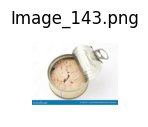

./recyclable-and-household-waste-classification/images/images/cardboard_packaging/real_world/Image_127.png


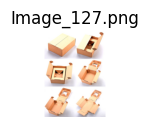

./recyclable-and-household-waste-classification/images/images/office_paper/default/Image_26.png


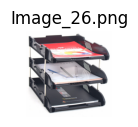

./recyclable-and-household-waste-classification/images/images/aerosol_cans/real_world/Image_224.png


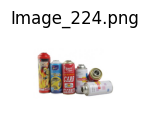

./recyclable-and-household-waste-classification/images/images/eggshells/default/Image_206.png


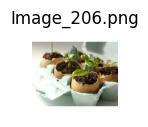

In [6]:
# Display a few random sample images
NUM_SAMPLES_TO_DISPLAY = 5

for i in range(NUM_SAMPLES_TO_DISPLAY):
    image_path = image_paths[random.randrange(len(image_paths))]
    print(image_path)
    image = Image.open(image_path)

    # Display the image
    plt.subplot(1, 5, i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(os.path.basename(image_path))
    plt.show()

In [7]:
DEFAULT_DIR = "default"
REAL_WORLD_DIR = "real_world"

# Ensure directories exist
os.makedirs(TRAIN_DIR, exist_ok = True)
os.makedirs(TEST_DIR, exist_ok = True)

def default_or_realworld(image_path):
    # this is kind of hacky to look for it as a string
    # a better way would be to step "up" one directory and see what it is
    if DEFAULT_DIR in image_path.lower():
        return DEFAULT_DIR
    elif REAL_WORLD_DIR in image_path.lower():
        return REAL_WORLD_DIR
    else:
        raise ValueError(image_path + " does not contain " + DEFAULT_DIR + " or " + REAL_WORLD_DIR)

# Process each class in the source directory
for class_name in os.listdir(IMAGE_DIR):
    class_path = os.path.join(IMAGE_DIR, class_name)
    if os.path.isdir(class_path):  # Ensure it’s a directory (class folder)
        print("Processing " + class_name + "...")

        # Create class folders in train and test directories
        os.makedirs(os.path.join(TRAIN_DIR, class_name), exist_ok = True)
        os.makedirs(os.path.join(TEST_DIR, class_name), exist_ok = True)

        # Collect all image file paths from any subdirectories within this class folder
        images = []
        for root, _, files in os.walk(class_path):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):  # Check for image file extensions
                    images.append(os.path.join(root, file))

        # Shuffle and split images into 80/20 train/test
        random.shuffle(images)
        split_idx = int(len(images) * 0.8)
        train_images = images[: split_idx]
        test_images = images[split_idx :]

        # Copy images to train and test directories
        # there are duplicate file names in the default and real
        # world directories, so add that onto the names to make them
        # unique. also only copy if not already present so subsequent
        # runs are faster if this is already done
        for image_path in train_images:
            dest_path = os.path.join(TRAIN_DIR, class_name, default_or_realworld(image_path) + os.path.basename(image_path))
            if os.path.exists(dest_path) == False:
                shutil.copyfile(image_path, dest_path)

        for image_path in test_images:
            dest_path = os.path.join(TEST_DIR, class_name, default_or_realworld(image_path) + os.path.basename(image_path))
            if os.path.exists(dest_path) == False:
                shutil.copyfile(image_path, dest_path)

print("Dataset successfully split into train and test folders!")

Processing aerosol_cans...
Processing disposable_plastic_cutlery...
Processing eggshells...
Processing office_paper...
Processing steel_food_cans...
Processing plastic_straws...
Processing styrofoam_cups...
Processing cardboard_boxes...
Processing newspaper...
Processing clothing...
Processing aluminum_soda_cans...
Processing glass_food_jars...
Processing plastic_cup_lids...
Processing coffee_grounds...
Processing cardboard_packaging...
Processing plastic_soda_bottles...
Processing tea_bags...
Processing food_waste...
Processing plastic_trash_bags...
Processing paper_cups...
Processing magazines...
Processing plastic_shopping_bags...
Processing plastic_water_bottles...
Processing glass_beverage_bottles...
Processing shoes...
Processing aluminum_food_cans...
Processing styrofoam_food_containers...
Processing plastic_food_containers...
Processing plastic_detergent_bottles...
Processing glass_cosmetic_containers...
Dataset successfully split into train and test folders!


In [9]:
# return the valid ones too, cause if the directory
# doesn't exist then there are 0 invalid and it
# seems like everything is ok when it isn't.
def check_images(directory):
    invalid_images = []
    valid_images = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith('.png'):
                try:
                    img = Image.open(os.path.join(root, file))
                    # note: this returns none and throws an exception if invalid
                    # (I was expecting it to return a bool- exceptions shouldn't
                    # be used for flow control)
                    img.verify()  # Verify image integrity
                    valid_images.append(os.path.join(root, file))
                except Exception as e:
                    invalid_images.append(os.path.join(root, file))
    return valid_images, invalid_images

valid_train, invalid_train = check_images(TRAIN_DIR)
valid_test, invalid_test = check_images(TEST_DIR)

print("Valid train images: " + str(len(valid_train)) + ", invalid train images: " + str(len(invalid_train)))
print("Valid test images: " + str(len(valid_test)) + ", invalid test images: " + str(len(invalid_test)))

total_found = (len(valid_train) + len(invalid_train) + len(valid_test) + len(invalid_test))
print("Total images found in training and testing sets: " + str(total_found))
print("Expected images from source: " + str(len(image_paths)))
if  total_found != len(image_paths):
    print("MISSING FILES IN TESTING OR TRAINING SET!!!")
else:
    print("Found all expected files in training and testing")

Valid train images: 12000, invalid train images: 0
Valid test images: 3000, invalid test images: 0
Total images found in training and testing sets: 15000
Expected images from source: 15000
Found all expected files in training and testing


In [14]:
IMG_SIZE = 224
BATCH_SIZE = 64

# Define data transformations
# numbers based on Maha's code
custom_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),  # Resize images to a consistent size
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize with ImageNet mean and std
])

## Load datasets
train_dataset = ImageFolder(root = TRAIN_DIR, transform = custom_transform)
val_loader_dataset = ImageFolder(root = TEST_DIR, transform = custom_transform)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = True)

In [15]:
# there is a very small, but non-zero chance that one of
# the data sets is missing an entire class- so account for that
train_class_names = train_dataset.classes
test_class_names = test_dataset.classes

class_names = set(train_class_names + test_class_names)

print("Class labels:", class_names)

num_classes = len(class_names)
print("\nNumber of classes: " + str(num_classes))

Class labels: {'newspaper', 'plastic_shopping_bags', 'plastic_food_containers', 'plastic_water_bottles', 'magazines', 'office_paper', 'aluminum_soda_cans', 'glass_beverage_bottles', 'coffee_grounds', 'food_waste', 'plastic_trash_bags', 'glass_cosmetic_containers', 'clothing', 'steel_food_cans', 'eggshells', 'aluminum_food_cans', 'styrofoam_food_containers', 'plastic_cup_lids', 'plastic_straws', 'cardboard_boxes', 'shoes', 'cardboard_packaging', 'paper_cups', 'plastic_soda_bottles', 'plastic_detergent_bottles', 'disposable_plastic_cutlery', 'tea_bags', 'styrofoam_cups', 'aerosol_cans', 'glass_food_jars'}

Number of classes: 30


In [12]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model (e.g., ResNet18)
model = models.resnet18(pretrained=True)
num_classes = len(train_dataset.classes)  # Get the number of classes from the dataset
model.fc = nn.Linear(model.fc.in_features, num_classes)  # Adjust the final layer

model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 128MB/s]


In [16]:
import matplotlib.pyplot as plt

# Initialize lists to store loss and accuracy values
train_losses = []
val_accuracies = []

# Training loop with tracking
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate average training loss for this epoch
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}")

    # Validation
    model.eval()
    correct, total = 0, 0
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)  # Validation loss
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate average validation loss and accuracy for this epoch
    avg_val_loss = val_loss / len(val_loader)
    accuracy = 100 * correct / total
    val_accuracies.append(accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {accuracy:.2f}%")


Epoch [1/10], Training Loss: 1.9386
Validation Loss: 1.0250, Validation Accuracy: 72.47%
Epoch [2/10], Training Loss: 0.8555
Validation Loss: 0.7132, Validation Accuracy: 79.97%
Epoch [3/10], Training Loss: 0.6088
Validation Loss: 0.5814, Validation Accuracy: 82.63%
Epoch [4/10], Training Loss: 0.4688
Validation Loss: 0.5153, Validation Accuracy: 84.60%
Epoch [5/10], Training Loss: 0.3689
Validation Loss: 0.4680, Validation Accuracy: 85.37%
Epoch [6/10], Training Loss: 0.2951
Validation Loss: 0.4483, Validation Accuracy: 86.20%
Epoch [7/10], Training Loss: 0.2417
Validation Loss: 0.4269, Validation Accuracy: 86.37%
Epoch [8/10], Training Loss: 0.2021
Validation Loss: 0.4155, Validation Accuracy: 86.70%
Epoch [9/10], Training Loss: 0.1681
Validation Loss: 0.4134, Validation Accuracy: 86.47%
Epoch [10/10], Training Loss: 0.1444
Validation Loss: 0.4122, Validation Accuracy: 86.53%


In [18]:
val_losses = [
    1.0250,  # Validation Loss for Epoch 1
    0.7132,  # Validation Loss for Epoch 2
    0.5814,  # Validation Loss for Epoch 3
    0.5153,  # Validation Loss for Epoch 4
    0.4680,  # Validation Loss for Epoch 5
    0.4483,  # Validation Loss for Epoch 6
    0.4269,  # Validation Loss for Epoch 7
    0.4155,  # Validation Loss for Epoch 8
    0.4134,  # Validation Loss for Epoch 9
    0.4122   # Validation Loss for Epoch 10
]


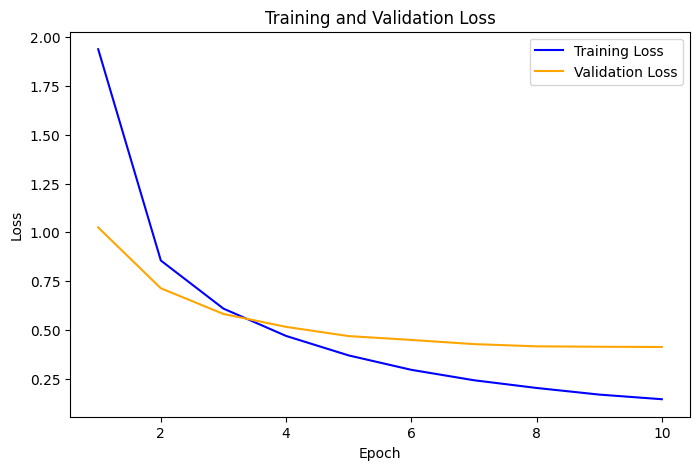

In [19]:
# Plot training and validation losses on the same plot
plt.figure(figsize=(8, 5))

# Plot training loss
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', color='blue')

# Plot validation loss
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', color='orange')

# Add labels, title, and legend
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()


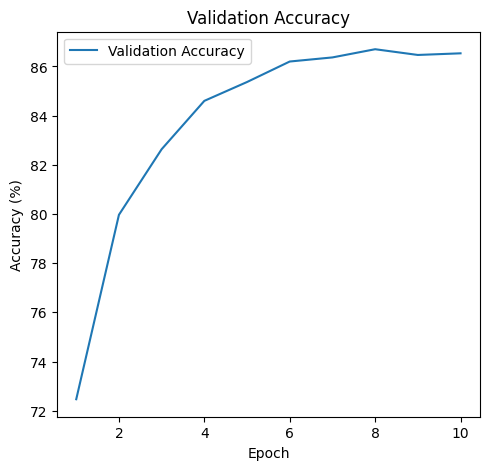

In [20]:
# Plot training loss and validation accuracy
plt.figure(figsize=(12, 5))

# Plot validation accuracy
#plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy')
plt.legend()

plt.show()